In [2]:
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, classification_report, roc_curve

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
class SupervisedNet(nn.Module):
    def __init__(self, input_dim):
        super(SupervisedNet, self).__init__()
        self.fc1 = nn.Linear(input_dim, 16)
        self.dropout1 = nn.Dropout(0.2)
        self.fc2 = nn.Linear(16, 8)
        self.dropout2 = nn.Dropout(0.2)
        self.fc3 = nn.Linear(8, 1)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout1(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout2(x)
        x = torch.sigmoid(self.fc3(x))
        return x

In [4]:
test_file = r"C:\Users\aryan\Desktop\CC\data\processed\test.csv"
df_test = pd.read_csv(test_file)
print("Test data shape:", df_test.shape)
X_test = df_test.drop('Class', axis=1).values.astype(np.float32)
y_test = df_test['Class'].values.astype(np.float32)
X_test_tensor = torch.from_numpy(X_test).to(device)

Test data shape: (56962, 31)


In [7]:
input_dim = X_test.shape[1]
model = SupervisedNet(input_dim).to(device)
model_path = r"C:\Users\aryan\Desktop\CC\models\supervised_model.pth"
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()

SupervisedNet(
  (fc1): Linear(in_features=30, out_features=16, bias=True)
  (dropout1): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=16, out_features=8, bias=True)
  (dropout2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=8, out_features=1, bias=True)
)

Test ROC AUC Score: 0.9815
Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     56864
         1.0       0.69      0.85      0.76        98

    accuracy                           1.00     56962
   macro avg       0.84      0.92      0.88     56962
weighted avg       1.00      1.00      1.00     56962



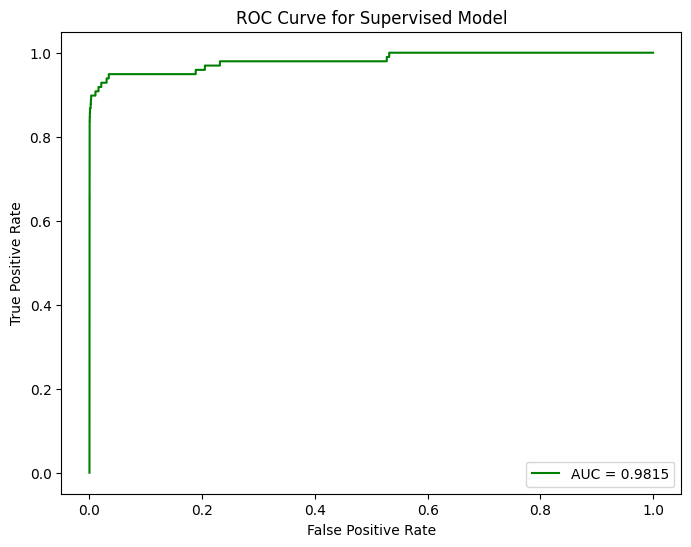

In [8]:
with torch.no_grad():
    outputs = model(X_test_tensor)
    y_pred_prob = outputs.cpu().numpy()
    y_pred = (y_pred_prob > 0.5).astype(int)

auc_score = roc_auc_score(y_test, y_pred_prob)
print(f"Test ROC AUC Score: {auc_score:.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Plot ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'AUC = {auc_score:.4f}', color='green')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Supervised Model")
plt.legend(loc="lower right")
plt.show()